In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
class FNN():
    """
    入力、隠れ、出力層の順伝播型ニューラルネットワーク

    """

    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate, batch_size):
        # 入力層、隠れ層、出力層のノード数を設定
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        self.batch_size = batch_size

        # 平均0、標準偏差1の正規分布に従う
        # self.w2 = np.random.randn(self.hnodes, self.inodes)
        # self.b2 = np.zeros((self.hnodes, 1))
        # self.w3 = np.random.randn(self.onodes, self.hnodes)
        # self.b3 = np.zeros((self.onodes, 1))

        # Xavierの初期値
        self.w2 = np.random.normal(0.0, pow(1 / self.inodes, 0.5), (self.hnodes, self.inodes))
        self.b2 = np.zeros((self.hnodes,1))
        self.w3 = np.random.normal(0.0, pow(1 / self.hnodes, 0.5), (self.onodes, self.hnodes))
        self.b3 = np.zeros((self.onodes,1))

        # 学習率の設定
        self.lr = learningrate

    def train(self, inputs_list, target_list):        
        inputs = np.array(inputs_list).reshape( self.inodes, -1)
        targets = np.array(target_list).reshape(-1,self.onodes)

        z2, u2, z3, loss = self.forward(inputs_list, target_list, train=True)
        print("loss", loss)

        o = z3

        # deltaの計算
        # 出力層の誤差 = (最終出力 - 目標出力)
        delta_3 = o - targets.T
        delta_2 = self.d_sigmoid(u2) * (np.dot(self.w3.T, delta_3))

        #　重みを更新
        self.b3 += self.lr * (-np.dot(delta_3, np.ones((self.batch_size,1))))
        self.w3 += self.lr * (-np.dot(delta_3, z2.T))
        self.b2 += self.lr * (-np.dot(delta_2, np.ones((self.batch_size,1))))
        z1 = inputs
        self.w2 += self.lr * (-np.dot(delta_2, z1.T))

        return loss


    def forward(self, inputs_list, target_list=None, train=False):
        # 入力リストを行列に変換
        inputs = np.array(inputs_list).reshape( self.inodes, -1)

        # 隠れ層
        u2 = np.dot(self.w2, inputs) + np.dot(self.b2, np.ones((inputs.shape[1],1)).T)

        # 隠れ層で結合された信号を活性化関数により出力
        z2 = self.sigmoid(u2)

        # 出力層
        u3 = np.dot(self.w3, z2) + np.dot(self.b3, np.ones((inputs.shape[1],1)).T)

        # 出力層で結合された信号を活性化関数により出力
        z3 = self.softmax(u3)

        if target_list is not None:
            targets = np.array(target_list).reshape(-1,self.onodes)
            loss = self.cross_entropy_error(z3,targets)
            if train:
                return z2, u2, z3, loss 
            return z3, loss

        return z3

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))

    def softmax(self, x):
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y


    def cross_entropy_error(self, y, t):
        """
        交差エントロピー誤差を計算する

        Parameters
        ----------
        y : numpy.ndarray
            ニューラルネットの出力

        t : numpy.ndarray
            教師データ(one-hot表現)

        Returns
        -------
        error : numpy.ndarray
            計算した誤差
        """

        batch_size = y.shape[1]

        # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
        if t.size == y.size:
            t = t.argmax(axis=1)

        delta = 1e-7
        y = y.T
        error = -np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size

        return error

In [43]:
input_nodes = 784  #  mnistの場合28*28=794
hidden_nodes = 100  # 隠れ層のサイズ
output_nodes = 10  # mnistの場合0 ~ 9

learning_rate = 0.01  # 学習率

batch_size = 100
epoch = 10  # 学習回数

In [44]:
network = FNN(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size)

mnistデータセットのダウンロード

In [45]:
# !wget https://pjreddie.com/media/files/mnist_test.csv`

In [46]:
# !wget https://pjreddie.com/media/files/mnist_train.csv

データの読み込み

In [47]:
with open("mnist_train.csv", 'r') as f:
    training_data = f.readlines()

In [48]:
with open("mnist_test.csv", 'r') as f:
    test_data = f.readlines()

In [49]:
print(len(training_data))  # データ数の確認‘
print(len(test_data))

60000
10000


In [50]:
training_data = np.array(training_data)

学習

In [51]:
train_loss = []  # 学習誤差
test_loss = []  # テスト誤差
train_accuracy = []
test_accuracy = []

# 学習
for i in range(epoch):
    idx = np.random.permutation(len(training_data))
    print("epoch:", i)
    for j in range(0,60000, batch_size):  # ランダムに並べ直したすべてのデータで学習する
        data = training_data[idx[j:j+batch_size]]
        x_batch = []
        for k in data:
            x_batch.append(list(map(lambda x: int(x) , k.split(",")[1:])))
        x_batch = np.array(x_batch).T / 255.0
        y_batch = [ int(k[0]) for k in data]
        
        target = np.zeros(( batch_size, output_nodes))
        
        # one-hot表現に変更
        for k in range(batch_size):
            target[k, y_batch[k]] = 1

        network.train(x_batch,target)
    
    # テスト誤差を求める
    loss = 0
    score = 0
    test_size = 10000
    for j in range(0,test_size,batch_size):
        data = test_data[j:j+batch_size]
        
        x_batch = []
        t = []
        for k in data:
            x_batch.append(list(map(lambda x: int(x) , k.split(",")[1:])))
            t.append(int(k.split(",")[0]))
        x_batch = np.array(x_batch).T / 255.0
        y_batch = [ int(k[0]) for k in data]
        
        target = np.zeros(( batch_size, output_nodes))
        
        # one-hot表現に変更
        for k in range(batch_size):
            target[k, y_batch[k]] = 1
        output, loss_ = network.forward(x_batch, target)
        loss += loss_
        labels = np.argmax(output.T, axis=1)
        score += np.sum(labels == t)
        
    test_loss.append(loss/(test_size/batch_size))
    test_accuracy.append(score / test_size)
    
    # 学習誤差を求める
    loss = 0
    score = 0
    test_size = 60000
    for j in range(0,test_size,batch_size):
        data = training_data[j:j+batch_size]
        
        x_batch = []
        t = []
        for k in data:
            x_batch.append(list(map(lambda x: int(x) , k.split(",")[1:])))
            t.append(int(k.split(",")[0]))
        x_batch = np.array(x_batch).T / 255.0
        y_batch = [ int(k[0]) for k in data]
        
        target = np.zeros(( batch_size, output_nodes))
        
        # one-hot表現に変更
        for k in range(batch_size):
            target[k, y_batch[k]] = 1
    
        output, loss_ = network.forward(x_batch, target)
        loss += loss_
        labels = np.argmax(output.T, axis=1)
        score += np.sum(labels == t)
    
    train_loss.append(loss/(test_size/batch_size))
    train_accuracy.append(score / test_size)

epoch: 0
loss 2.3538178067341984
loss 2.749998173844118
loss 3.553681759112357
loss 3.3195566046149296
loss 2.9501499289756765
loss 2.314082401200815
loss 2.1876520364481506
loss 2.1013908325348987
loss 1.9762784525823271
loss 2.0061781449945655
loss 1.9451617750792378
loss 1.819398589689656
loss 1.761672679624593
loss 1.6234317106936735
loss 1.673177120903418
loss 1.6322389596894065
loss 1.5101102969948772
loss 1.478833423672395
loss 1.3378792813456035
loss 1.357152949127875
loss 1.3267873428506816
loss 1.2055986936799643
loss 1.3148385867598982
loss 1.1514055921428192
loss 1.05678411977006
loss 1.1585874512883243
loss 0.981000967047412
loss 1.1172623737625946
loss 1.0968651518412036
loss 0.8901547830819848
loss 1.0178320785727837
loss 0.8116882697913402
loss 0.9991896463922477
loss 0.845785002417523
loss 0.9167679643413074
loss 0.9056790303487402
loss 0.669956668587489
loss 0.7794295057397922
loss 0.8080253964523837
loss 0.6518465555348715
loss 0.705561329527958
loss 0.64745205719838

loss 0.43279959588025163
loss 0.31094549662809934
loss 0.17538927263252763
loss 0.42286651683715276
loss 0.32825563018658444
loss 0.3556793195050823
loss 0.2392397430464057
loss 0.3295962882207221
loss 0.23108801651200434
loss 0.3719820856679064
loss 0.20020647185766705
loss 0.27353393703416307
loss 0.3208253218409386
loss 0.28108980692576174
loss 0.24055372873193004
loss 0.3452864699440052
loss 0.17572174615901712
loss 0.4102680562108164
loss 0.4025058942095324
loss 0.3013409158648845
loss 0.3278056464857507
loss 0.21603881458687582
loss 0.30100899217837646
loss 0.25720197029413366
loss 0.23847195535945043
loss 0.4686262560605188
loss 0.22188807756399817
loss 0.20947203373006537
loss 0.1666129361265838
loss 0.3047732568395432
loss 0.2684351068909411
loss 0.29689252669391536
loss 0.3688097938247269
loss 0.26221375693357607
loss 0.29104015655962495
loss 0.4936448745795483
loss 0.27568349750745513
loss 0.23627705150724274
loss 0.2537192962914111
loss 0.3157718842400383
loss 0.30620353072

loss 0.2180270090954006
loss 0.21559441561917495
loss 0.15874103047635998
loss 0.1893477198237155
loss 0.2621663906818212
loss 0.31718446448974574
loss 0.35045944282916813
loss 0.30310035725831846
loss 0.1371483221206113
loss 0.2502985575062665
loss 0.22807678503600973
loss 0.20362266207669907
loss 0.11632642999656148
loss 0.14796139712428988
loss 0.34642945411408077
loss 0.16391333719456075
loss 0.20065681431157123
loss 0.35609929561883624
loss 0.21248345584231182
loss 0.1497678804168485
loss 0.22980808094255825
loss 0.3274697722363517
loss 0.16749218195996043
loss 0.23350079829673334
loss 0.3725372714545984
loss 0.2142188937538731
loss 0.2821087566263327
loss 0.28578334156279744
loss 0.24257402330492334
loss 0.17809467560812844
loss 0.2367861761679392
loss 0.16088979444613102
loss 0.19202968161934636
loss 0.14848618107749545
loss 0.30964185317307935
loss 0.32035890422412344
loss 0.31801452671142577
loss 0.280936780247725
loss 0.2417988220629803
loss 0.1704886485568025
loss 0.17762821

loss 0.13820873666045597
loss 0.2318615771141438
loss 0.15630466233745627
loss 0.12183579887880792
loss 0.18548558371424054
loss 0.25676793077764676
loss 0.12363506229114735
loss 0.1790131430060878
loss 0.13439586260676037
loss 0.16305657657367142
loss 0.21111287416230504
loss 0.1128802148095584
loss 0.08364634568792471
loss 0.25574171354809344
loss 0.1390228830982195
loss 0.1782477637721886
loss 0.19437373747554698
loss 0.11530903513598881
loss 0.14907373018372777
loss 0.2043383234892031
loss 0.2215103602307757
loss 0.17812187941029026
loss 0.10992768195410442
loss 0.2216544643460907
loss 0.24407237738279808
loss 0.19635911329123637
loss 0.2279590692579199
loss 0.24933528281912534
loss 0.08701138080648825
loss 0.27005654594410644
loss 0.23632979569273566
loss 0.24516554520118927
loss 0.10791516784270064
loss 0.11165708372428224
loss 0.2683582243043775
loss 0.16483970121299954
loss 0.23489544507302504
loss 0.2099038983920638
loss 0.1739959543484448
loss 0.16196712009515823
loss 0.21950

loss 0.2178901506101432
loss 0.25463282115441926
loss 0.0969532499968712
loss 0.11573820584950731
loss 0.2222507653904422
loss 0.11879826299399016
loss 0.18882695418161724
loss 0.20590420463536738
loss 0.3004175183583367
loss 0.2848333436964454
loss 0.11000273116587944
loss 0.19848913450937478
loss 0.20420374530600058
loss 0.10829736301252427
loss 0.2049521013324425
loss 0.0724367753193173
loss 0.15017270089662738
loss 0.16528939401442003
loss 0.1653126443904821
loss 0.12675739604259298
loss 0.1044344804591412
loss 0.13753783044563078
loss 0.17319764084132153
loss 0.21594666330863063
loss 0.17857360513235862
loss 0.13521275927606913
loss 0.22953213708867015
loss 0.1169929277134977
loss 0.17521561079014325
loss 0.14590211369676692
loss 0.10741940891844068
loss 0.19992885725854573
loss 0.07758769299071525
loss 0.2200805466383577
loss 0.18720229035698613
loss 0.16966496212135207
loss 0.20779479569210138
loss 0.16596701000704198
loss 0.13887161078469723
loss 0.1318095579510774
loss 0.30606

loss 0.2726440708480157
loss 0.13065133172185456
loss 0.20050086356376604
loss 0.17886163782166764
loss 0.19437783093208985
loss 0.10867672581316144
loss 0.12667956631895771
loss 0.08593500545475019
loss 0.1065820197150085
loss 0.14401410379906485
loss 0.09227026047254651
loss 0.18418998779157444
loss 0.1112088167801197
loss 0.1739443899034069
loss 0.13515090699769503
loss 0.11926993019756348
loss 0.18528248238100162
loss 0.16333109652098377
loss 0.2107105476226947
loss 0.0676647019663204
loss 0.30198161904434706
loss 0.1602824885092121
loss 0.18385093939099076
loss 0.18554895861840393
loss 0.11960164780608137
loss 0.09774103710080836
loss 0.08896043972907342
loss 0.2031513498672478
loss 0.11150726501240911
loss 0.2144933411027811
loss 0.17799608132089018
loss 0.0980184255285086
loss 0.09437767427609224
loss 0.20461081990835453
loss 0.07278378129792543
loss 0.2704082841977047
loss 0.1515162255263352
loss 0.06629531007238004
loss 0.18088511087265488
loss 0.15704300656605297
loss 0.08628

loss 0.10229093639106654
loss 0.15790698392823355
loss 0.06635176666542368
loss 0.13263061463978928
loss 0.18288072596091903
loss 0.11024333880011074
loss 0.11914710750214377
loss 0.12181791656763491
loss 0.20507965136029252
loss 0.07612480229260943
loss 0.1122726231095602
loss 0.16282627682167042
loss 0.14373813600276097
loss 0.10156951961388103
loss 0.09681853327310266
loss 0.11365497567005545
loss 0.09963781878530815
loss 0.11439767418193304
loss 0.09167826780467887
loss 0.13314089525557699
loss 0.12775727586788663
loss 0.1503873498798624
loss 0.0919037270522786
loss 0.09680314569726166
loss 0.07479184624579378
loss 0.10375998147246766
loss 0.05175689428430505
loss 0.12873757046767675
loss 0.09566084539975638
loss 0.12411785346158041
loss 0.03431918855853553
loss 0.13200665082024834
loss 0.14632806562805784
loss 0.0949666616010792
loss 0.13758845500970976
loss 0.058589766995814675
loss 0.10671890792253105
loss 0.22172190897967575
loss 0.11375022058099842
loss 0.26726468987588586
los

loss 0.07641901895812317
loss 0.1307393257802022
loss 0.13920650297041365
loss 0.05497162706623359
loss 0.20196166733568272
loss 0.10528311147465899
loss 0.13371381872437468
loss 0.06806344332613591
loss 0.135085076072129
loss 0.07328411182594513
loss 0.09109450265300938
loss 0.17852812398141485
loss 0.11543334428167736
loss 0.12314349559500208
loss 0.03716901995265946
loss 0.05239134575844329
loss 0.08961687375421368
loss 0.19571040547034277
loss 0.0814448811639997
loss 0.07273550887734183
loss 0.10308349861645652
loss 0.13626603769144383
loss 0.19105598893368334
loss 0.18512773779807554
loss 0.2179603877990062
loss 0.08715648145445222
loss 0.1725393288895654
loss 0.14843275332337677
loss 0.11337006026037312
loss 0.10924739620962372
loss 0.15993700043821854
loss 0.1000475707384648
loss 0.0842318568610896
loss 0.12036121356932554
loss 0.10412892744211259
loss 0.11073114624320138
loss 0.1439858266744616
loss 0.06819127461192834
loss 0.0775653839145597
loss 0.06045434814071857
loss 0.123

loss 0.12748292315977597
loss 0.1552773242248776
loss 0.13819195720464114
loss 0.10795403099949191
loss 0.05659384241548544
loss 0.13431270442555573
loss 0.1533923102343682
loss 0.14081719626592062
loss 0.0989927880606843
loss 0.09129405397037621
loss 0.12730964985142407
loss 0.11743711890680827
loss 0.10511455197040304
loss 0.04891269891175935
loss 0.08590564567334498
loss 0.13100759819504815
loss 0.10726398264530673
loss 0.04899178238475439
loss 0.11490408530601201
loss 0.11639713064264517
loss 0.1984405056124756
loss 0.056069065796748675
loss 0.0629824333105894
loss 0.11066232999305761
loss 0.19665873299692702
loss 0.10827776692094444
loss 0.07755627876906276
loss 0.05249324245088578
loss 0.07165826043974632
loss 0.07603314460458133
loss 0.18882721625978838
loss 0.13507617586292103
loss 0.13892540378735066
loss 0.080487583763148
loss 0.067313988797792
loss 0.21914505060019634
loss 0.11190288685496194
loss 0.09291258055036905
loss 0.11794821096386618
loss 0.04595207645475588
loss 0.0

loss 0.058376634636428386
loss 0.09209794638140693
epoch: 5
loss 0.09138918047086829
loss 0.07849308777398117
loss 0.0514353463162954
loss 0.11852384278047795
loss 0.0472548029952089
loss 0.07950801506869387
loss 0.029117756978368575
loss 0.1905556940811393
loss 0.07809735768705706
loss 0.09660585970756114
loss 0.05017524441290914
loss 0.09281111042289783
loss 0.04402421993816407
loss 0.07015241937433624
loss 0.07152179252522642
loss 0.062312816638236124
loss 0.07927203301710674
loss 0.10546342402486694
loss 0.11959781662820576
loss 0.04992112126364438
loss 0.07637622786721597
loss 0.062638013394881
loss 0.1439719800935519
loss 0.1390567819908405
loss 0.12849924543190822
loss 0.15614814963992885
loss 0.1382547369342887
loss 0.09140706452135927
loss 0.06474102994963282
loss 0.057546610336139385
loss 0.08927926567467524
loss 0.07801579681794474
loss 0.1523989151143958
loss 0.05195368580429889
loss 0.07855886757782392
loss 0.11901703288093408
loss 0.0791288112219262
loss 0.046637847403115

loss 0.07601956287059285
loss 0.0787249358371616
loss 0.08104388860143405
loss 0.05306193206651342
loss 0.0702261255716768
loss 0.10341305249896654
loss 0.07648869956613036
loss 0.06915984139819539
loss 0.11878036921164
loss 0.14751300653104477
loss 0.053424041036436325
loss 0.04477641614368601
loss 0.05441006855194035
loss 0.03271428759524459
loss 0.054248727321820366
loss 0.08320107111767891
loss 0.10945436188608568
loss 0.07787079206635507
loss 0.10059219143636877
loss 0.09040427644130808
loss 0.12245996655194397
loss 0.08893370135780698
loss 0.06079306132959736
loss 0.08806150779312709
loss 0.07686332552423819
loss 0.12378440821319614
loss 0.07256532406356242
loss 0.07204503573284807
loss 0.09437652966716
loss 0.09307631534827618
loss 0.058426335442813525
loss 0.14419981037725751
loss 0.041377656824716766
loss 0.05739336917100684
loss 0.04148127531859704
loss 0.10298132291927393
loss 0.16059595815675087
loss 0.07235987518494152
loss 0.09296047602526597
loss 0.06950430612565507
loss

loss 0.10642831433633387
loss 0.07432011611060607
loss 0.04528816876152408
loss 0.08193676635457281
loss 0.06638540230765554
loss 0.035399015170540046
loss 0.028649043184938626
loss 0.040035058602931384
loss 0.09136223444730338
loss 0.07189007291775996
loss 0.14211218231557834
loss 0.10744865019825837
loss 0.03497311258301591
loss 0.13622341558849288
loss 0.12727160910864807
loss 0.06213671962663038
loss 0.039510428978673066
loss 0.09791839413579721
loss 0.08225263612845846
loss 0.0710960713142724
loss 0.04099867127274704
loss 0.14572866927377695
loss 0.026825550015321834
loss 0.10758782808226755
loss 0.06264197127693419
loss 0.08429152974931203
loss 0.05045829900287785
loss 0.056149806439407396
loss 0.03080179328519036
loss 0.052705294329828394
loss 0.0962496934561783
loss 0.18063028685720237
loss 0.07222556292295942
loss 0.05902457817705571
loss 0.024431127592199023
loss 0.08293651045395331
loss 0.05201373353683272
loss 0.035187581326179405
loss 0.04615946722152877
loss 0.06789467503

loss 0.03702888657269561
loss 0.04497388332068926
loss 0.10287438091291431
loss 0.062365399435600016
loss 0.08821963595348677
loss 0.037545201580003774
loss 0.15020618866507005
loss 0.07836122269895808
loss 0.045179438753680495
loss 0.049887684375584496
loss 0.06709069233077511
loss 0.16389347919816782
loss 0.05109041114607313
loss 0.0637756216820787
loss 0.11067997264892356
loss 0.028553984620795007
loss 0.11640509296462737
loss 0.0323180573005724
loss 0.035549620287229335
loss 0.08310428185886767
loss 0.18175324863476516
loss 0.06049965103617043
loss 0.09671345429009197
loss 0.060482021968629444
loss 0.08423785739074063
loss 0.06464614153208639
loss 0.02344960343803064
loss 0.09061718741496545
loss 0.05707425666897845
loss 0.13127511199926728
loss 0.08515710675848892
loss 0.025305665454855606
loss 0.02501140891503046
loss 0.08019112305407684
loss 0.05708334219785896
loss 0.07559701841293215
loss 0.032347279253213124
loss 0.05728892506444249
loss 0.06551691375462075
loss 0.02675152692

loss 0.05688022206658661
loss 0.0731325441153445
loss 0.04549251888934526
loss 0.07452445554386485
loss 0.038707869332800196
loss 0.08086171446251272
loss 0.05936738675590006
loss 0.018883134459511598
loss 0.04813275551995583
loss 0.07564670958430292
loss 0.08210523358386436
loss 0.04903615025860697
loss 0.02874814789776039
loss 0.036041439209765685
loss 0.06506452467181999
loss 0.052100517222894854
loss 0.03970395888622092
loss 0.036163177179206786
loss 0.07198325099283859
loss 0.08060263127456258
loss 0.06561276925950557
loss 0.05984715440788016
loss 0.06774214632041785
loss 0.03675295419530721
loss 0.0819457080505542
loss 0.15046831179254352
loss 0.03937116726859846
loss 0.033596576786873736
loss 0.05019379338668729
loss 0.1381961807368622
loss 0.042893752666688885
loss 0.06244080833902855
loss 0.044476426204831304
loss 0.08631863816018043
loss 0.04554806810161753
loss 0.02689654406642934
loss 0.04178550148638041
loss 0.04368357737480526
loss 0.09820575912339001
loss 0.0754509698464

loss 0.08791791544219503
loss 0.03196148135628386
loss 0.08255474122168856
loss 0.053210360794887966
loss 0.06326828244914148
loss 0.036055906737869396
loss 0.14387177248675395
loss 0.04761592236906347
loss 0.1609962696765327
loss 0.05113573151555592
loss 0.03905813315519084
loss 0.0849380236285122
loss 0.037183800993486116
loss 0.048771112091429994
loss 0.014281808669132362
loss 0.11738192246649426
loss 0.10993513602866281
loss 0.08799755902203478
loss 0.01738679120603363
loss 0.17044532097242435
loss 0.07495455665575759
loss 0.054032566466347506
loss 0.04850156453676721
loss 0.1425595545937093
loss 0.07428728227571274
loss 0.07113290993453074
loss 0.1524361645422589
loss 0.05293687009351837
loss 0.0333462229610809
loss 0.058377894318312265
loss 0.0495811344828502
loss 0.11200234046241755
loss 0.04412837048003037
loss 0.039667544932089634
loss 0.04588765893407477
loss 0.11169678542052487
loss 0.0485543994961583
loss 0.1408360708080198
loss 0.16033493725176776
loss 0.053749388285254954

loss 0.02709349186595594
loss 0.052130516211478566
loss 0.06028795014447545
loss 0.02983515966140656
loss 0.10969801274165361
loss 0.07469835504843148
loss 0.08301903209655338
loss 0.11472185663884488
loss 0.07410052170632173
loss 0.07124417564092453
loss 0.02622239529586563
loss 0.11240246035044944
loss 0.023774912041143192
loss 0.09054842289987076
loss 0.06977255270772773
loss 0.08297146401649971
loss 0.05540699975781181
loss 0.12517044945136613
loss 0.08350326107806852
loss 0.11391468459411475
loss 0.06635717582633806
loss 0.0582727926777972
loss 0.04869951239669947
loss 0.06718772508723418
loss 0.10311557804226773
loss 0.04819409516186961
loss 0.030312285374720242
loss 0.0494990188828211
loss 0.06181317853879551
loss 0.1924213892392759
loss 0.09020775949090803
loss 0.04187898142240194
loss 0.03781572228604462
loss 0.17947820858812924
loss 0.02858491780502072
loss 0.05229727906297719
loss 0.06590813473824618
loss 0.08285544707388742
loss 0.0261474940909352
loss 0.09199495925396044
l

loss 0.039933364426446134
loss 0.027338140983694532
loss 0.026724620395686318
loss 0.044783767944026893
loss 0.0711728128824138
loss 0.1706520425419556
loss 0.0649605230540696
loss 0.025253797438456776
loss 0.057850939531149795
loss 0.04604888195976549
loss 0.046775091901434855
loss 0.08290349324108848
loss 0.019877395320698554
loss 0.072724129654206
loss 0.06922849525387727
loss 0.032567933613944146
loss 0.08762086082795598
loss 0.028725801668131556
loss 0.0554284903793401
loss 0.04670668368332375
loss 0.06432857046713676
loss 0.02460768097462731
loss 0.12320308263360284
loss 0.022784564488563416
loss 0.04547665561070066
loss 0.03153816510045905
loss 0.07461881175655809
loss 0.1266916542916684
loss 0.0954540526582758
loss 0.09072521865233268
loss 0.013216626944155287
loss 0.0426689072670087
loss 0.020721151536481533
loss 0.054227785905252054
loss 0.04018077760776664
loss 0.038778315909206475
loss 0.04403261415802368
loss 0.09083378848319673
loss 0.06571511026175368
loss 0.055288816563

loss 0.03898130196487442
loss 0.0378964058412189
loss 0.04378907375104836
loss 0.016744864917852497
loss 0.025196072280405143
loss 0.06355514783239567
loss 0.050609129460195836
loss 0.008885037807035999
loss 0.03622344591755646
loss 0.05086221233253319
loss 0.03277436913939116
loss 0.06923900688656809
loss 0.04117755302872591
loss 0.10515709377431225
loss 0.032028775788633355
loss 0.08399606504069139
loss 0.13479408188021402
loss 0.05727152966509963
loss 0.029602419681600805
loss 0.1220663100606749
loss 0.018975967174823975
loss 0.10022172056248431
loss 0.07166140132162427
loss 0.05912456633621401
loss 0.05561969700512755
loss 0.06596961355050589
loss 0.03741595033460539
loss 0.13818688024110493
loss 0.05701140232640659
loss 0.06347217294926505
loss 0.05299350416100001
loss 0.0894938285102869
loss 0.04284839589518243
loss 0.0493592553763348
loss 0.018847077295708593
loss 0.04444814927012901
loss 0.05043997272911401
loss 0.054347614519803945
loss 0.08074967966841953
loss 0.0226498605088

loss 0.04040625715317014
loss 0.06413679686947811
loss 0.0678230409747883
loss 0.03239272500230024
loss 0.06514410170945056
loss 0.059017393534605465
loss 0.03905360783383529
loss 0.05840051109746143
loss 0.024198720450173114
loss 0.06394140819415953
loss 0.011855943632536996
loss 0.06437431044867542
loss 0.03312195672863638
loss 0.08668385315658261
loss 0.08101635971998576
loss 0.05883325131652681
loss 0.04882346883088438
loss 0.02703851178953623
loss 0.08390505247518186
loss 0.025448497729846236
loss 0.1270055894492358
loss 0.11720226056141339
loss 0.03963086103680546
loss 0.06212121151818004
loss 0.14036186521534166
loss 0.042686804856682005
loss 0.03284342032670308
loss 0.07301058266542397
loss 0.04821216748655074
loss 0.0814352492662793
loss 0.05044124964260943
loss 0.07745387820009751
loss 0.022808725701829013


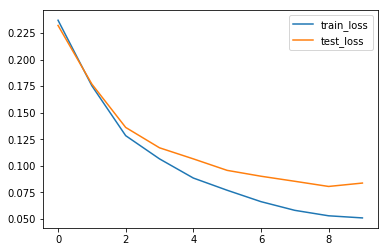

In [53]:
plt.plot(train_loss[:], label="train_loss")
plt.plot(test_loss[:], label="test_loss")
plt.legend()
plt.show()

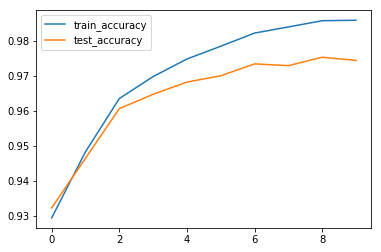

In [54]:
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(test_accuracy, label="test_accuracy")
plt.legend()
plt.show()

In [55]:
with open("mnist_test.csv", 'r') as f:
    test_data = f.readlines()

score = 0
test_size = 10000
for i in range(0,test_size,batch_size):
    data = test_data[i:i+batch_size]
    
    x_batch = []
    t = []
    for j in data:
        x_batch.append(list(map(lambda x: int(x) , j.split(",")[1:])))
        t.append(int(j.split(",")[0]))
    x_batch = np.array(x_batch).T / 255.0
    
    output = network.forward(x_batch)
    labels = np.argmax(output.T, axis=1)
    score += np.sum(labels == t)


print("正解率 =", score / test_size)

正解率 = 0.9745


In [56]:
with open("mnist_train.csv", 'r') as f:
    training_data = f.readlines()
    
score = 0
test_size = 60000
for i in range(0,test_size,batch_size):
    data = training_data[i:i+batch_size]
    
    x_batch = []
    t = []
    for j in data:
        x_batch.append(list(map(lambda x: int(x) , j.split(",")[1:])))
        t.append(int(j.split(",")[0]))
    x_batch = np.array(x_batch).T / 255.0
    
    output = network.forward(x_batch)
    labels = np.argmax(output.T, axis=1)
    score += np.sum(labels == t)

print("正解率 =", score / test_size)

正解率 = 0.9859833333333333


### irisデータセット

In [57]:
from sklearn import datasets

In [58]:
iris = datasets.load_iris()

In [59]:
target = iris["target"]
data = iris["data"]

In [60]:
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [61]:
data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [62]:
data[:,0] /= np.max(data[:,0])
data[:,1] /= np.max(data[:,1])
data[:,2] /= np.max(data[:,2])
data[:,3] /= np.max(data[:,3])

In [63]:
for i in range(150):
    print(i,data[i], target[i])

0 [0.64556962 0.79545455 0.20289855 0.08      ] 0
1 [0.62025316 0.68181818 0.20289855 0.08      ] 0
2 [0.59493671 0.72727273 0.1884058  0.08      ] 0
3 [0.58227848 0.70454545 0.2173913  0.08      ] 0
4 [0.63291139 0.81818182 0.20289855 0.08      ] 0
5 [0.6835443  0.88636364 0.24637681 0.16      ] 0
6 [0.58227848 0.77272727 0.20289855 0.12      ] 0
7 [0.63291139 0.77272727 0.2173913  0.08      ] 0
8 [0.55696203 0.65909091 0.20289855 0.08      ] 0
9 [0.62025316 0.70454545 0.2173913  0.04      ] 0
10 [0.6835443  0.84090909 0.2173913  0.08      ] 0
11 [0.60759494 0.77272727 0.23188406 0.08      ] 0
12 [0.60759494 0.68181818 0.20289855 0.04      ] 0
13 [0.5443038  0.68181818 0.15942029 0.04      ] 0
14 [0.73417722 0.90909091 0.17391304 0.08      ] 0
15 [0.72151899 1.         0.2173913  0.16      ] 0
16 [0.6835443  0.88636364 0.1884058  0.16      ] 0
17 [0.64556962 0.79545455 0.20289855 0.12      ] 0
18 [0.72151899 0.86363636 0.24637681 0.12      ] 0
19 [0.64556962 0.86363636 0.2173913  0.12

In [64]:
idx = np.random.permutation(len(data))
print(idx)
train_x, train_y, test_x, test_y = data[idx[:100]], target[idx[:100]], data[idx[100:]], target[idx[100:]]

[135   3  76  69   1  54 124  48  82  57  17  72 132  91  60  73  44  68
 140  36  16 113  96  50 128   4  97 111   6 148  30  75  90  25 104  89
  52  39 118  28  94  70  33  23   8 145 131  77  92 134  32  51 107 120
 112  55  74   7  46 101  13  49  87 106  88  34 110 149   5 136  78 108
   0 137  27  98  99 121  65 127  64  93 116  47  21  22  53  38  29  43
  86 129 141 102 139 138  83 105 146  95  59 123  81 109 115  41  62  42
  37  45  79  84 100  15  12  63  71 119  14  67  35  58  19 144  11 133
  40 103 125 114  20  26  18   9  31  85 147  61  66 126 122 130 117  24
  80  10  56 142   2 143]


In [103]:
input_nodes = 4  #  irisの場合4
hidden_nodes = 4  # 隠れ層のサイズ
output_nodes = 3  # irisdatasetの場合0 ~ 2

learning_rate = 0.01  # 学習率

batch_size = 10
epoch = 500 # 学習回数

In [104]:
network = FNN(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size)

In [105]:
train_y

array([2, 1, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2,
       1, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 1, 2, 0, 0, 1, 2,
       2, 2, 2, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1,
       0, 2, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1,
       1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1])

In [106]:
def shuffle(x,y):
    x_y = list(zip(x,y))
    np.random.shuffle(x_y)
    result_x, result_y = zip(*x_y)
    return np.asarray(result_x), np.asarray(result_y)

In [107]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy =[]

for i in range(epoch):
    print("epoch:", i)
    train_x, train_y = shuffle(train_x, train_y)
    for j in range(0,100, batch_size):  # 並び返したすべてのデータで学習する
        x_batch = train_x[j:j+batch_size]
        y_batch = np.zeros(( batch_size, output_nodes))
        
        # one-hot表現に変更
        for k in range(batch_size):
            y_batch[k, train_y[j+k]] = 1
        
        network.train(x_batch.T,y_batch)
    
    # テスト誤差を求める
    loss = 0
    score = 0
    test_size = 50
    for j in range(0,test_size,batch_size):
        x_batch = test_x[j:j+batch_size]
        y_batch = np.zeros(( batch_size, output_nodes))
        
        # one-hot表現に変更
        for k in range(batch_size):
            y_batch[k, test_y[j+k]] = 1
         
        t = test_y[j:j+batch_size]
        output, loss_ = network.forward(x_batch.T, y_batch)
        loss += loss_
        labels = np.argmax(output.T, axis=1)
        score += np.sum(labels == t)
    
    test_loss.append(loss/(test_size/batch_size))
    test_accuracy.append(score/test_size)
    
    # 学習誤差を求める
    loss = 0
    score = 0
    test_size = 100
    for j in range(0,test_size,batch_size):
        x_batch = train_x[j:j+batch_size]
        y_batch = np.zeros(( batch_size, output_nodes))
        
        # one-hot表現に変更
        for k in range(batch_size):
            y_batch[k, train_y[j+k]] = 1
         
        t = test_y[j:j+batch_size]
        output, loss_ = network.forward(x_batch.T, y_batch)
        loss += loss_
        t = train_y[j:j+batch_size]
        output = network.forward(x_batch.T)
        labels = np.argmax(output.T, axis=1)
        score += np.sum(labels == t)
    
    train_loss.append(loss/(test_size/batch_size))
    train_accuracy.append(score/test_size)

epoch: 0
loss 1.1353833438007785
loss 1.051913361032749
loss 1.1622255868468825
loss 1.077686208369904
loss 1.1318972074086058
loss 1.1122868661033447
loss 1.1081631910247025
loss 1.0885146857390122
loss 1.1099929255151504
loss 1.0702134811992374
epoch: 1
loss 1.0702118013624926
loss 1.0516164598490927
loss 1.081009562015397
loss 1.122024430801537
loss 1.0935421230658613
loss 1.0933918422390605
loss 1.0886290725641627
loss 1.1146624026138907
loss 1.0790041989382255
loss 1.0816774145175962
epoch: 2
loss 1.074230036654817
loss 1.0664745536931792
loss 1.0967669311568107
loss 1.0661574960041262
loss 1.0712529823148826
loss 1.0816657776214476
loss 1.0710738532500588
loss 1.1075952164511391
loss 1.0830496686774285
loss 1.0732068556327128
epoch: 3
loss 1.0472636887827418
loss 1.111673972919037
loss 1.0760678546881353
loss 1.0980211750066242
loss 1.0666253813572621
loss 1.0755625030631317
loss 1.059668624785652
loss 1.0546791765507115
loss 1.0548693711068227
loss 1.1241525409991147
epoch: 4
lo

loss 0.4893100796008227
loss 0.3961429174965891
loss 0.4922857394642417
loss 0.5763655458351724
loss 0.4476484772744936
loss 0.5533609485147357
epoch: 67
loss 0.4445653758354088
loss 0.5642401735463956
loss 0.4560969347907438
loss 0.4754807616090296
loss 0.6382264055370885
loss 0.43130182453230564
loss 0.4812181365368821
loss 0.5882080144827061
loss 0.49065775819491836
loss 0.6106677936316791
epoch: 68
loss 0.526741793994073
loss 0.410208070843353
loss 0.46315767665793367
loss 0.6293940749568196
loss 0.5503508932745639
loss 0.5334642292340392
loss 0.5695625169377393
loss 0.42265310340807966
loss 0.5054272910853215
loss 0.5183144135356506
epoch: 69
loss 0.5487994783957839
loss 0.4886775282358767
loss 0.6073988133189744
loss 0.4072352347096923
loss 0.431117081053409
loss 0.539473465761102
loss 0.5402456805996225
loss 0.5757662070182489
loss 0.41513391754089735
loss 0.5720729504016376
epoch: 70
loss 0.5850045385410657
loss 0.470016271095138
loss 0.4907365755738421
loss 0.5834826810375731


loss 0.40788776186076897
loss 0.4320287541622626
loss 0.4198205008900994
loss 0.36110250980022063
loss 0.40131720863253106
loss 0.3756958342039586
loss 0.41605379266302006
loss 0.4968910668920793
loss 0.291815911435548
epoch: 105
loss 0.371082135872543
loss 0.40008061365952885
loss 0.4918774639997235
loss 0.3420485619874964
loss 0.39275475524027154
loss 0.4279589499431752
loss 0.39972022214760883
loss 0.3784822459437026
loss 0.4633985597623953
loss 0.3403928967449927
epoch: 106
loss 0.349537232823427
loss 0.2765628134572747
loss 0.4459287240513303
loss 0.38666759572941134
loss 0.38141472879379235
loss 0.39048429280552
loss 0.37814096411867903
loss 0.49121565356992286
loss 0.43958594323594224
loss 0.3931768398797503
epoch: 107
loss 0.5266246464741082
loss 0.40884404621062326
loss 0.3699824445837418
loss 0.41535318469831717
loss 0.3841008045540988
loss 0.2849710222119046
loss 0.426766101537028
loss 0.3527839921791425
loss 0.29650369086445105
loss 0.4291952960434868
epoch: 108
loss 0.3122

epoch: 140
loss 0.3795468591366298
loss 0.33929281773369324
loss 0.28832501961070583
loss 0.25676758613890116
loss 0.40471129743454914
loss 0.3527793115529
loss 0.2858480404687966
loss 0.3586505105558651
loss 0.22867174661119433
loss 0.2887048761837853
epoch: 141
loss 0.27424897131580905
loss 0.3232614686240666
loss 0.3017809021333725
loss 0.3740551511054421
loss 0.2203943345841534
loss 0.26030801404614873
loss 0.3161243320919563
loss 0.4005277029141002
loss 0.35429815943488785
loss 0.3323935631063953
epoch: 142
loss 0.2323302627105417
loss 0.2846089833714039
loss 0.23721096438955355
loss 0.44824067686486524
loss 0.25615551396851494
loss 0.2998899003176607
loss 0.32340785316510046
loss 0.24210433895716016
loss 0.43886459902234487
loss 0.36180180622788327
epoch: 143
loss 0.2680331322187894
loss 0.24552486823177025
loss 0.2593248079539788
loss 0.46948943876889926
loss 0.27279745342256406
loss 0.30573512119124147
loss 0.3284902760156698
loss 0.4102708864516204
loss 0.2808337659931953
loss

loss 0.2222361535661173
epoch: 177
loss 0.2822671361324057
loss 0.16766532455063116
loss 0.24766300348712936
loss 0.21769170385543699
loss 0.36381343992131154
loss 0.21082372895057108
loss 0.2257703205546823
loss 0.244034881728507
loss 0.3631425817229551
loss 0.24051089615802215
epoch: 178
loss 0.3200216501189722
loss 0.2990455811845804
loss 0.3006690809388338
loss 0.18507894567360678
loss 0.1389458990869144
loss 0.24900052953221832
loss 0.2545768813394638
loss 0.16864083155596857
loss 0.2894521752977332
loss 0.3480080311373585
epoch: 179
loss 0.22755705852522534
loss 0.2508564029660917
loss 0.2683653746325031
loss 0.3416815730358532
loss 0.2914030360522712
loss 0.2366592172488741
loss 0.24866122231869686
loss 0.2034270644652006
loss 0.23444364131350973
loss 0.22277391408308128
epoch: 180
loss 0.23254643299996736
loss 0.2001578288784461
loss 0.23804948430859824
loss 0.17157263320648936
loss 0.3699835774968092
loss 0.19286329939614083
loss 0.24417796596933633
loss 0.30094663435406754
lo

epoch: 212
loss 0.21282674795681103
loss 0.13991730283441386
loss 0.19017886729293515
loss 0.2569093363837191
loss 0.2034310554120165
loss 0.272681453108038
loss 0.24678517468709246
loss 0.16967455083046987
loss 0.21688268576995556
loss 0.22653084562088424
epoch: 213
loss 0.1758827905027746
loss 0.28819633652218213
loss 0.23070121543887914
loss 0.13011396356396443
loss 0.1822620590644003
loss 0.24388653075212172
loss 0.31359866206235115
loss 0.13228635268323444
loss 0.1986894254517039
loss 0.2290257364230353
epoch: 214
loss 0.27371269572370005
loss 0.17179252675790918
loss 0.2501936004613871
loss 0.25217076172868713
loss 0.2437039110808165
loss 0.19515365385170158
loss 0.21653891315386295
loss 0.23650160538971185
loss 0.10057747891282114
loss 0.1817823383770599
epoch: 215
loss 0.15994394588803504
loss 0.1345427438019771
loss 0.24452979780137457
loss 0.24046834696564984
loss 0.17309502670179794
loss 0.19903009967759583
loss 0.2839980634308401
loss 0.17122653245620495
loss 0.250062325942

epoch: 248
loss 0.17967995666972703
loss 0.13814119063725516
loss 0.22934672275794837
loss 0.1082229271769515
loss 0.2704359035685833
loss 0.1924201338391264
loss 0.24255558091061072
loss 0.23209398187073144
loss 0.07715715378889261
loss 0.16284689421711704
epoch: 249
loss 0.16016084816624687
loss 0.16747369628307537
loss 0.14666470255932867
loss 0.19143028618460595
loss 0.2616130929820998
loss 0.11680440535897
loss 0.25913115856269486
loss 0.22642591559055378
loss 0.1265554833778489
loss 0.17227716472276122
epoch: 250
loss 0.3053120912602357
loss 0.24699875460204476
loss 0.153435485023992
loss 0.1962522218390497
loss 0.0937184450658975
loss 0.26194247675013616
loss 0.10726167528611279
loss 0.1812683067529764
loss 0.16514330671103772
loss 0.11005733851888792
epoch: 251
loss 0.2584923330235397
loss 0.14690838064676237
loss 0.1611483816703151
loss 0.1507089967021206
loss 0.25523699901621616
loss 0.21778441190233355
loss 0.09657696997200944
loss 0.1027293776591515
loss 0.21641808310565563

epoch: 286
loss 0.14782888570683103
loss 0.09787100586236613
loss 0.13064406559019184
loss 0.2026829941188903
loss 0.15131958126706246
loss 0.09063253779462899
loss 0.22280546500391657
loss 0.2569962927201969
loss 0.1641612156844467
loss 0.13885836757406197
epoch: 287
loss 0.07293338631592841
loss 0.13277343669786346
loss 0.28016967309939406
loss 0.16119071375260555
loss 0.2191571802742683
loss 0.08746633199915468
loss 0.13076933213698166
loss 0.3063191399154571
loss 0.1306729918257488
loss 0.08361796047553698
epoch: 288
loss 0.11445299730487968
loss 0.17992722235970648
loss 0.09248503678291053
loss 0.2712309185275559
loss 0.09866802421373959
loss 0.10312031937832444
loss 0.12573474602788534
loss 0.25126568323768805
loss 0.19147497191341648
loss 0.17023919769116538
epoch: 289
loss 0.12813953643873205
loss 0.1603021884534118
loss 0.1575438600281503
loss 0.16514153852297236
loss 0.10448191438176105
loss 0.15770446068410615
loss 0.27049056823359136
loss 0.23243957346412641
loss 0.09471372

epoch: 321
loss 0.18112233018313695
loss 0.10014340386219775
loss 0.08277932466309318
loss 0.13431232807586407
loss 0.17876092433614402
loss 0.2560138824045947
loss 0.08648689274828684
loss 0.19567740300357334
loss 0.1381763701504483
loss 0.09650665176654663
epoch: 322
loss 0.19693571701072823
loss 0.07478234944323534
loss 0.24954810632369323
loss 0.0872565080463042
loss 0.18190077848489214
loss 0.08800916419678864
loss 0.2501933532436462
loss 0.08986424572704069
loss 0.1417978366057365
loss 0.1141157812400339
epoch: 323
loss 0.14820348301174577
loss 0.07594438183919232
loss 0.13531635289468252
loss 0.05524387642187186
loss 0.15141494729263902
loss 0.22650422070177592
loss 0.2467441971633641
loss 0.17383439088207328
loss 0.15436539214268463
loss 0.0836139431626884
epoch: 324
loss 0.09894496681832668
loss 0.11371405035137186
loss 0.12988927198301348
loss 0.25313385808705574
loss 0.21909865158129702
loss 0.13266933116672439
loss 0.11317113396597889
loss 0.19280047396367786
loss 0.1442350

loss 0.10969290787356437
loss 0.06906036125552836
loss 0.15303633029359318
epoch: 356
loss 0.23698086578848945
loss 0.1869182097734123
loss 0.1779438519545576
loss 0.05933771553064297
loss 0.06979358175155609
loss 0.12436807001232601
loss 0.0762826451016183
loss 0.11386634105868806
loss 0.0883123786092999
loss 0.19022829488881604
epoch: 357
loss 0.0674174089101071
loss 0.09924128118533095
loss 0.05549708695173999
loss 0.27153859097928934
loss 0.07220004570836316
loss 0.16890930152850392
loss 0.2242118700476028
loss 0.11592667175259194
loss 0.05153193916575396
loss 0.1917957440108004
epoch: 358
loss 0.10331734849860097
loss 0.22876781314484815
loss 0.12040324538469982
loss 0.1736048945583491
loss 0.14865738334496395
loss 0.08870599766500126
loss 0.06240805348910975
loss 0.0521826111630274
loss 0.15898710825475937
loss 0.1868573204855491
epoch: 359
loss 0.07567536386717413
loss 0.1685476592999979
loss 0.07702867566952867
loss 0.08806270772167056
loss 0.15420500577258847
loss 0.1292620897

epoch: 388
loss 0.08362930455556075
loss 0.2063960365321226
loss 0.08551863944049418
loss 0.10503627592386751
loss 0.07171772880722566
loss 0.12041162444476827
loss 0.10617338008368644
loss 0.10305619463336757
loss 0.15056049367689
loss 0.20581431535256392
epoch: 389
loss 0.17691709068433706
loss 0.1742569228406638
loss 0.09298419955802271
loss 0.21049959124444398
loss 0.09110255198627429
loss 0.10167941419854891
loss 0.11418109667886009
loss 0.06122471999450768
loss 0.16348192528623434
loss 0.05626782048236769
epoch: 390
loss 0.08190359143430564
loss 0.14074919105364375
loss 0.16584311964242004
loss 0.29182271628523904
loss 0.09926830823430141
loss 0.12419731399409484
loss 0.0392243352856851
loss 0.050208382696181775
loss 0.09805570816670987
loss 0.13667966901967774
epoch: 391
loss 0.08195486685418832
loss 0.10755985625603552
loss 0.15143057841359867
loss 0.09068096808000992
loss 0.09117876785734384
loss 0.13161282470460564
loss 0.24424865525292372
loss 0.06641363655557224
loss 0.1816

loss 0.062099093029933064
loss 0.06836071079685142
loss 0.10764063263991977
loss 0.04835021480868606
loss 0.16112821715019437
loss 0.17827983260823527
loss 0.1286200489908666
loss 0.13417586237475917
epoch: 443
loss 0.03591352183414655
loss 0.05601406917967777
loss 0.20331122117947137
loss 0.05718343457319504
loss 0.13699208546259203
loss 0.2543865340148609
loss 0.13788863172954813
loss 0.12391733585254257
loss 0.06826687976522097
loss 0.03362336490403789
epoch: 444
loss 0.0670267445856122
loss 0.08979139969154921
loss 0.12718544962824352
loss 0.12999675362204186
loss 0.23096187938468543
loss 0.15805207996388365
loss 0.08868302594059072
loss 0.07764570559388288
loss 0.05852036163136498
loss 0.10320265128343258
epoch: 445
loss 0.10951568836775745
loss 0.15773483536213379
loss 0.14718356462446325
loss 0.06136039735262453
loss 0.05959196736547995
loss 0.12859195263870365
loss 0.05188709327630907
loss 0.1176544030971662
loss 0.08266466114841159
loss 0.20010014891651884
epoch: 446
loss 0.13

loss 0.15903285251348903
loss 0.037561482114175905
loss 0.048227092668115305
epoch: 493
loss 0.04236929589436771
loss 0.03633036650291083
loss 0.1074531791691844
loss 0.08726103859133025
loss 0.20790829798740443
loss 0.10837341661136776
loss 0.07700356860657394
loss 0.0811520859782904
loss 0.13944129212763345
loss 0.1435254922847135
epoch: 494
loss 0.05107150359787556
loss 0.1300020533335146
loss 0.05005119271232117
loss 0.1519131020412522
loss 0.1250030312035425
loss 0.03288708889920699
loss 0.15572751589172423
loss 0.18422810402652137
loss 0.12530818788458406
loss 0.0416126363411317
epoch: 495
loss 0.1829809388475853
loss 0.17753484578809897
loss 0.027974550012727206
loss 0.1322459041499372
loss 0.03162470806328797
loss 0.13595858257318433
loss 0.04165705007342217
loss 0.11586419313322845
loss 0.14548162591412706
loss 0.06792865927179505
epoch: 496
loss 0.1492567664513485
loss 0.04651887908910678
loss 0.07907396573717185
loss 0.1842813089121142
loss 0.14549011608392684
loss 0.1251387

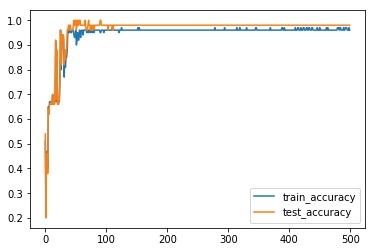

In [108]:
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(test_accuracy, label="test_accuracy")
plt.legend()
plt.show()

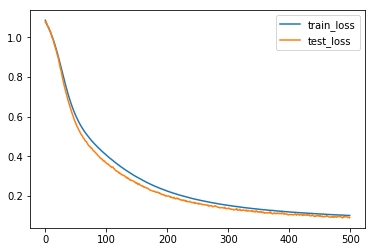

In [109]:
plt.plot(train_loss[:], label="train_loss")
plt.plot(test_loss[:], label="test_loss")
plt.legend()
plt.show()

In [110]:
score = 0
test_size = 100
for i in range(0,test_size,batch_size):
    x_batch = train_x[i:i+batch_size]
    t = train_y[i:i+batch_size]
    output = network.forward(x_batch.T)
    labels = np.argmax(output.T, axis=1)
    score += np.sum(labels == t)

print("正解率 =", score / test_size)

正解率 = 0.96


In [111]:
batch_size = 2
score = 0
test_size = 50
for i in range(0,test_size,batch_size):
    x_batch = test_x[i:i+batch_size]
    t = test_y[i:i+batch_size]
    output = network.forward(x_batch.T)
    labels = np.argmax(output.T, axis=1)
    score += np.sum(labels == t)

print("正解率 =", score / test_size)

正解率 = 0.98
